In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai') 
import numpy as np
import pandas as pd
from sklearn import svm

In [4]:
train = pd.read_csv("./train_maxmin.csv")
test = pd.read_csv("./test_maxmin.csv")
train_id = train["train_id"]
target = train["dbh"]
train = train.drop(["dbh","train_id"],axis=1)
test_id = test["test_id"]
test = test.drop(["test_id"],axis=1)
print(train.describe())

            max_h       min_h      mean_h        sd_h         sum_h  \
count  100.000000  100.000000  100.000000  100.000000    100.000000   
mean    31.256400   13.551000   25.116951    4.080438   3434.404894   
std      6.669115    7.094876    6.062526    1.764470   2177.420502   
min     21.010000    5.100000   14.525690    0.520348    243.139998   
25%     25.505000    8.372500   20.403993    2.917439   1873.557498   
50%     30.705000   11.980000   23.497401    3.866057   3170.640000   
75%     35.872500   16.355000   29.329508    5.200860   4608.217491   
max     47.230000   38.259998   40.867333    9.411008  11451.179980   

       crown_area  crown_perim      maxmin  
count   100.00000   100.000000  100.000000  
mean     22.13120    25.992000   17.705400  
std      12.88846     9.234451    7.923928  
min       2.08000     1.600000    1.760002  
25%      12.28000    20.800000   12.307500  
50%      20.16000    26.400000   17.215000  
75%      29.48000    32.800000   23.142501  


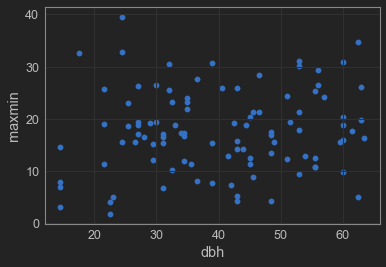

In [7]:
import matplotlib.pyplot as plt
x = target
y = train["maxmin"]
plt.scatter(x,y)
plt.xlabel("dbh")
plt.ylabel("maxmin")
plt.show()

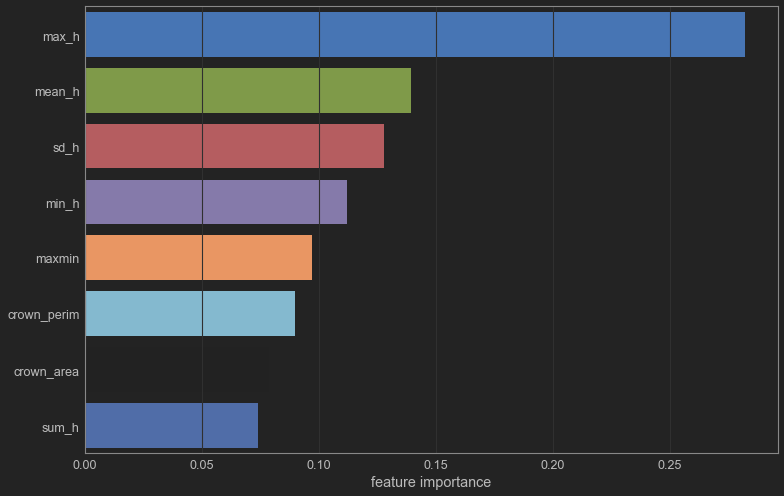

In [10]:
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor as RFR
rfr = RFR()
rfr.fit(train, target)
ranking = np.argsort(-rfr.feature_importances_)
f, ax = plt.subplots(figsize=(11, 7))
sns.barplot(x=rfr.feature_importances_[ranking], y=train.columns.values[ranking])
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

C:\Users\owner\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RMSE train : 13.053, valid : 11.214


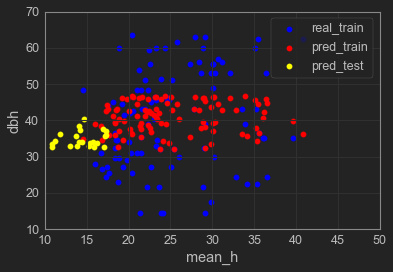

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

kf = KFold(n_splits=100,random_state=0)
svr = svm.SVR(C=50,kernel="rbf", epsilon=0.1)
results = []
for X_index, Y_index in kf.split(train):
    X_train = train.loc[X_index]
    Y_train = train.loc[Y_index]
    X_target, Y_target = target[X_index], target[Y_index]
    svr.fit(X_train,X_target)
    X_pred = svr.predict(X_train)
    Y_pred = svr.predict(Y_train)
    results.append(np.sqrt(mean_squared_error(Y_target,Y_pred)))
results = np.array(results)
print('RMSE train : %.3f, valid : %.3f' % (
    np.sqrt(mean_squared_error(X_target, X_pred)),
    results.mean()))

plt.scatter(train["mean_h"],target,color="blue",label="real_train")
plt.scatter(train["mean_h"],svr.predict(train),color="red",label="pred_train")
plt.scatter(test["mean_h"],svr.predict(test),color="yellow",label="pred_test")
plt.ylabel("dbh")
plt.xlabel("mean_h")
plt.xlim(10,50)
plt.ylim(10,70)
plt.legend(loc="upper right")
plt.show()

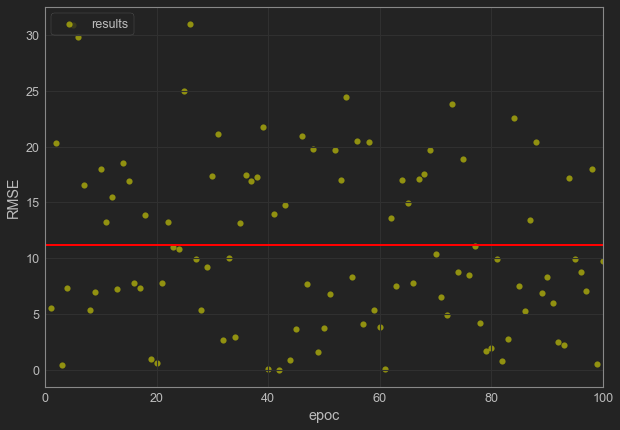

In [12]:
plt.figure(figsize = (10, 7))
plt.scatter(range(1,101), results, c = 'yellow', marker = 'o', s = 35, alpha = 0.5, label = 'results')
plt.xlabel('epoc')
plt.ylabel('RMSE')
plt.legend(loc = 'upper left')
plt.hlines(y = results.mean(), xmin = 0, xmax = 100, lw = 2, color = 'red')
plt.xlim([0, 100])
plt.show()

In [14]:
pred = pd.DataFrame()
pred["Id"] = test_id
pred["dbh"] = svr.predict(test)
pred["dbh"] = (pred["dbh"]).round(2)
pred.to_csv("crazy.csv", index=False)